In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import make_grid
import re

## Simple Multilayer Perceptron for MNIST

In [39]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [40]:
# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

Next we'll load the MNIST data. First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for validation, instead of for testing the final model.

In [41]:
train_dataset = FashionMNIST('../datasets',
                               train=True,
                               download=True,
                               transform=transform)

validation_dataset = FashionMNIST('../datasets',
                                    train=False,
                                    transform=transform)


batch_size = 32

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

And the first training images.

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


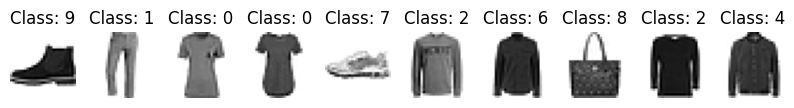

In [42]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())

    pltsize = 1
    plt.figure(figsize=(10 * pltsize, pltsize))

    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
        plt.title('Class: ' + str(y_train[i].item()))

    break

Let's define the network as a Python class. We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

In [43]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [44]:
model = BaseNetwork(act_fn=nn.ReLU()).to(device)

Finally, we define an optimizer to update the model parameters based on the computed gradients. We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01. Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [45]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

criterion = nn.CrossEntropyLoss()

In [46]:
model

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

Let's now define functions to `train()` and `validate()` the model.

In [47]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [48]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

Now we are ready to train our model using the `train()` function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`.

In [49]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309482
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.662431
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.732561
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.581023
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.443356
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.011859
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.673298
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.430220
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.691634
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.411606

Validation set: Average loss: 0.4706, Accuracy: 8290/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.462612
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.410779
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.486116
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.399383
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.486126
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.362010
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.634067
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.814177
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.56

Let's now visualize how the training progressed.
* *Loss* is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

Text(0.5, 1.0, 'validation loss')

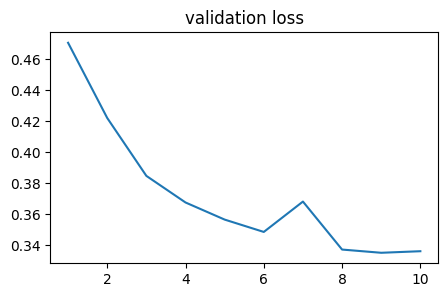

In [50]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

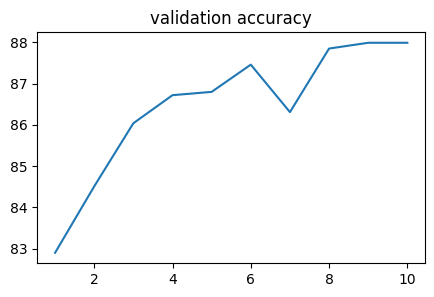

In [51]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

Defining lists with different hyperparameters. NN models will be created using combinations of parameters from these lists

In [52]:
diff_hyperparameters = [
    [128, 64],
    [264, 128],
    [128, 128, 64],
    [264, 128, 64],
    [512, 128, 64],
    [512, 264, 128],
    [512, 512, 128],
    [512, 512, 264, 128]
]

diff_learning_rates = [0.2, 0.1, 0.075, 0.05, 0.01, 0.001]

diff_momentums = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Defining the NN structure with different number of layers and neurons

In [53]:
loss_acc_by_hyperparameters = {}

for k, param in enumerate(diff_hyperparameters):
  model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=param).to(device)
  print('Model #', k + 1, sep='')
  print(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  epochs = 10
  loss_val, acc_val = [], []
  for epoch in range(1, epochs + 1):
    train(epoch)
    validate(loss_val, acc_val)
  loss_acc_by_hyperparameters[str(param)] = [loss_val[-1], acc_val[-1]]


Model #1
BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343158
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.770964
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.507663
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.410608
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.521806
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.490404
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.530257
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.347331
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.395050
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.557154

Validation set: Average loss: 0.4648, Accuracy: 8283/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.269216
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.417262
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.231843
Train Epoch: 2 [19200/60000 

In [54]:
loss_acc_by_hyperparameters

{'[128, 64]': [0.32721583053681025, tensor(88.2200)],
 '[264, 128]': [0.3304113791985141, tensor(88.2100)],
 '[128, 128, 64]': [0.337786761981665, tensor(88.1400)],
 '[264, 128, 64]': [0.3361440640647871, tensor(88.1500)],
 '[512, 128, 64]': [0.34513063585686926, tensor(87.8400)],
 '[512, 264, 128]': [0.3352624686489107, tensor(87.9700)],
 '[512, 512, 128]': [0.3261485284008229, tensor(88.5200)],
 '[512, 512, 264, 128]': [0.3249592785112682, tensor(88.5700)]}

We can notice that the results don't really differ, but still we can choose the NN with the best performance.
[264, 128, 64]
I wrote a function to automatically define the best NN struct.

In [55]:
def find_best_model(loss_acc_arr):
    max_acc = loss_acc_arr['[128, 64]'][1]
    best = [128, 64]
    for ind, v in loss_acc_arr.items():
        if v[1] > max_acc:
            max_acc = v[1]
            best = ind

    elements = re.findall(r'\d+', best)
    best = [int(x) for x in elements]
    return best
best_struct = find_best_model(loss_acc_by_hyperparameters)
print(best_struct)

[512, 512, 264, 128]


In [56]:
loss_acc_by_lr = {}
print('Model:', model, sep='\n')
# print(model)
for k, param in enumerate(diff_learning_rates):
  model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=best_struct).to(device)
  print(k + 1, '. Learning rate: ', param, sep='')
  # print(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=param, momentum=0.5)
  epochs = 15
  loss_val, acc_val = [], []
  for epoch in range(1, epochs + 1):
    train(epoch)
    validate(loss_val, acc_val)
  loss_acc_by_lr[param] = [loss_val[-1], acc_val[-1]]

Model:
BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=264, bias=True)
    (5): ReLU()
    (6): Linear(in_features=264, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)
1. Learning rate: 0.2
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310094
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.104100
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.333653
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.615653
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.651474
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.885596
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.392369
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.902017
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.490100
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.420247

Validation set: Average loss: 0.4377, Accuracy: 8304/10000 (

In [57]:
loss_acc_by_lr

{0.2: [0.3773116491226849, tensor(88.1000)],
 0.1: [0.3795626322937995, tensor(88.3800)],
 0.075: [0.3630726825028609, tensor(89.1400)],
 0.05: [0.34840605771821975, tensor(89.4600)],
 0.01: [0.3788672309200534, tensor(87.9200)],
 0.001: [0.40696278825179305, tensor(85.3800)]}

In [59]:
def find_best_learning_rate(loss_acc_arr_lr):
    max_acc = loss_acc_arr_lr[0.2][1]
    best = 0.2
    for ind, v in loss_acc_arr_lr.items():
        if v[1] > max_acc:
            max_acc = v[1]
            best = ind
    return best
best_learning_rate = find_best_learning_rate(loss_acc_by_lr)
print(best_learning_rate)

0.05


In [60]:
loss_acc_by_momentum = {}
print('Model:', model, sep='\n')
for k, param in enumerate(diff_momentums):
  model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=best_struct).to(device)
  print(k + 1, '. Momentum: ', param, sep='')
  optimizer = torch.optim.SGD(model.parameters(), lr=best_learning_rate, momentum=param)
  epochs = 10
  lossv, accv = [], []
  for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
  loss_acc_by_momentum[param] = [lossv[-1], accv[-1]]

Model:
BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=264, bias=True)
    (5): ReLU()
    (6): Linear(in_features=264, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)
1. Momentum: 0.2
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316572
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.924564
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.528808
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.517871
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.266498
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.347517
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.692249
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.580908
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.577465
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.457117

Validation set: Average loss: 0.4321, Accuracy: 8471/10000 (85%)


In [61]:
loss_acc_by_momentum

{0.2: [0.3428061713055979, tensor(87.9400)],
 0.3: [0.37690493802098246, tensor(86.8000)],
 0.4: [0.31693718395487047, tensor(89.4200)],
 0.5: [0.33316535260647717, tensor(89.0700)],
 0.6: [0.3575747135023963, tensor(88.0500)],
 0.7: [0.3332426529894827, tensor(88.6000)],
 0.8: [0.3637617936003048, tensor(88.5500)],
 0.9: [0.4439808837406308, tensor(86.7400)]}

In [63]:
def find_best_momentum(loss_acc_arr_momentum):
    max_acc = loss_acc_arr_momentum[0.2][1]
    best = 0.2
    for ind, v in loss_acc_arr_momentum.items():
        if v[1] > max_acc:
            max_acc = v[1]
            best = ind
    return best
best_momentum = find_best_momentum(loss_acc_by_momentum)
print(best_momentum)

0.4


In [65]:
model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=best_struct).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=best_learning_rate, momentum=best_momentum)

epochs = 15
lossv, accv = [], []
for epoch in range(1, epochs + 1):
  train(epoch)
  validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314120
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.724505
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.312627
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.473586
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.784944
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.327763
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.404455
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.619977
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.383998
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.601628

Validation set: Average loss: 0.4197, Accuracy: 8470/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.409175
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.496822
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.320138
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.387704
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.273218
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.561950
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.287834
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.460815
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.44

So, the best model is:

In [67]:
print('The best model struct: ', best_struct)
print('The best learning rate: ', best_learning_rate)
print('The best momentum: ', best_momentum)

The best model struct:  [512, 512, 264, 128]
The best learning rate:  0.05
The best momentum:  0.4


EVERYTHING IN ONE

In [68]:
loss_acc_by_model = {}
for k, param in enumerate(diff_hyperparameters):
  model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=param).to(device)
  print('Model #', k + 1, sep='')
  print(model)

  for lr_k, lr_param in enumerate(diff_learning_rates):
    print(lr_k + 1, '. Learning rate: ', lr_param, sep='')

    for m_k, m_param in enumerate(diff_momentums):
      print(m_k + 1, '. Momentum: ', m_param, sep='')
      optimizer = torch.optim.SGD(model.parameters(), lr=lr_param, momentum=m_param)
      epochs = 10
      loss_val, acc_val = [], []
      for epoch in range(1, epochs + 1):
        train(epoch)
        validate(loss_val, acc_val)
      loss_acc_by_model[str(param) + ' ' + str(lr_param) + str(m_param)] = [loss_val[-1], acc_val[-1]]

Model #1
BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
1. Learning rate: 0.2
1. Momentum: 0.2
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333808
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.253768
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.919976
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.378118
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.348259
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.495207
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.309473
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.296768
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.370192
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.435486

Validation set: Average loss: 0.4719, Accuracy: 8233/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.224239
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.299375
Train Epoch: 2 [12800/60000 (21%)]	Loss

KeyboardInterrupt: 

Text(0.5, 1.0, 'validation loss')

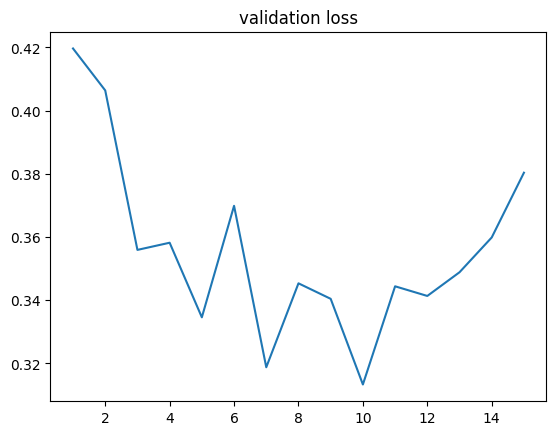

In [71]:
plt.plot(np.arange(1,15+1), lossv)
plt.title('validation loss')

Text(0.5, 1.0, 'validation accuracy')

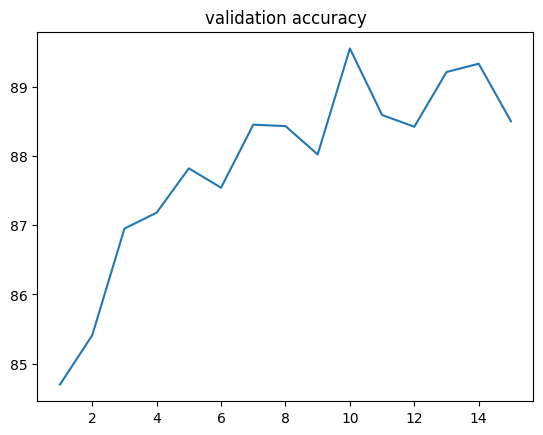

In [72]:
plt.plot(np.arange(1,15+1), accv)
plt.title('validation accuracy')

In [73]:
def model_errors(my_model, loader):
    my_model.eval()
    class_correct = [0] * 10
    class_total = [0] * 10
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)

            output = my_model(data)
            _, predicted = torch.max(output.data, 1)
            for ind in range(len(target)):
                label = target[ind]
                prediction = predicted[ind]
                if prediction != label:
                    class_correct[label] += 1
                class_total[label] += 1
    errors_list = [class_correct[ind] / class_total[ind] if class_total[ind] != 0 else 0 for ind in range(10)]
    return errors_list

Text(0.5, 1.0, 'errors by category')

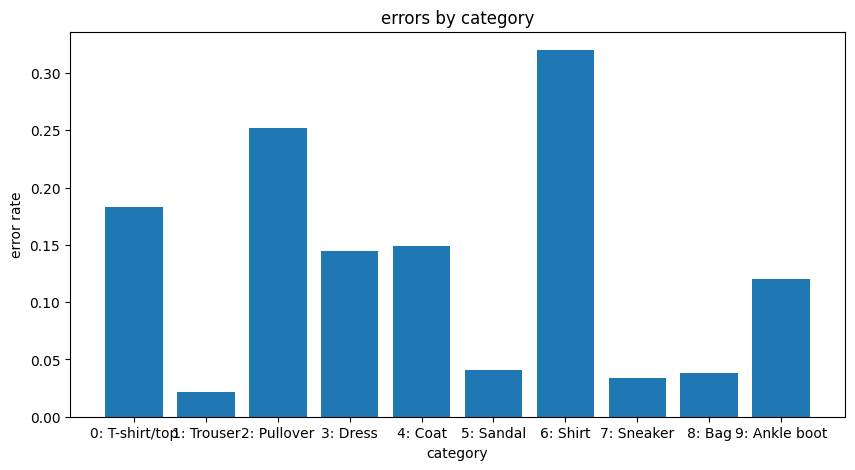

In [74]:
error_rates = model_errors(model, validation_loader)

plt.figure(figsize=(10, 5))
plt.bar(range(10), error_rates)
plt.xticks(range(10), ['0: T-shirt/top',
                       '1: Trouser',
                       '2: Pullover',
                       '3: Dress',
                       '4: Coat',
                       '5: Sandal',
                       '6: Shirt',
                       '7: Sneaker',
                       '8: Bag',
                       '9: Ankle boot'])
plt.xlabel('category')
plt.ylabel('error rate')
plt.title('errors by category')